In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency t
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import pickle

#test equal variance
from scipy.stats import levene

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score, r2_score,\
mean_squared_error, mean_absolute_error, explained_variance_score#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
from scipy.stats import pearsonr
import scipy.stats as stats


#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well


#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Define parameters

In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
path_extracted_data_visual_adap_clustering = os.path.join(path_extracted_data_visual_adap,'clustering')
path_extracted_data_visual_adap_clustering_chi2 = os.path.join(path_extracted_data_visual_adap_clustering,'chi2') 
path_extracted_data_visual_adap_clustering_dtw = os.path.join(path_extracted_data_visual_adap_clustering,'dtw') 
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_adap_clustering_chi2):
    os.makedirs(path_extracted_data_visual_adap_clustering_chi2)
if not os.path.exists(path_extracted_data_visual_adap_clustering_dtw):
    os.makedirs(path_extracted_data_visual_adap_clustering_dtw)
for nbr_bin in li_binmn:
    path_extracted_data_visual_adap_binmn = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability',str(nbr_bin))
    #create a director if not existing
    if not os.path.exists(path_extracted_data_visual_adap_binmn):
        os.makedirs(path_extracted_data_visual_adap_binmn)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


change the configuration file if not done yet!


# Download variables

In [5]:
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_visual_adap, 'li_selected_hens.pkl'), 'rb'))
len(li_selected_hens)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


132

In [6]:
#distance measure (chi2, dtw)
#_df_DistanceRoutineDev
df_interintra = pd.read_csv(os.path.join(path_extracted_data_visual_adap ,id_run+'_df_DistanceRoutineDev.csv'), sep=';', 
                      parse_dates=['level','level+1'], dayfirst=True)
#weeks of age starting on the first day where the bird was here during 24h
df_interintra['weeks_in_laying_barn'] = df_interintra['DOA'].map(lambda x: int((x-119)/7)+1)
display(df_interintra[['level','DOA','weeks_in_laying_barn']].drop_duplicates().reset_index().head(3))
#remove weeks_in_laying_barn to avoid confusions
df_interintra.drop(['WOA'],inplace=True,axis=1)
print(df_interintra.shape)
df_interintra = df_interintra[(df_interintra['henID1'].isin(li_selected_hens))&(df_interintra['henID2'].isin(li_selected_hens))]
print(df_interintra.shape)
df_interintra.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,level,DOA,weeks_in_laying_barn
0,0,2020-09-30,119,1
1,2153,2020-10-01,120,1
2,4306,2020-10-02,121,1


(97411, 101)
(97411, 101)


,level,level+1,henID1,henID2,PenID,Treatment,dur_values_normalized_henID1,dur_values_normalized_henID2,chi2distance,DOA,...,nbr_obs_l2_30_4_Zone,DTW_30_1_Zone,nbr_obs_l1_30_1_Zone,nbr_obs_l2_30_1_Zone,is_same_ind,type,HenID1_CLASS,HenID2_CLASS,CLASS,weeks_in_laying_barn
0,2020-09-30,2020-10-01,hen_102,hen_102,pen3,OFH,"[0.0, 0.010625, 0.19631944444444444, 0.0215625...","[0.0, 0.0, 0.0, 0.0, 1.0]",0.128991,119,...,5,NaN,5,5,True,Intra individuals - OFH,MEXP,MEXP,MEXP,1
1,2020-09-30,2020-10-01,hen_26,hen_82,pen5,OFH,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.434783950617284, 0.1385185185185185, 0...",0.411457,119,...,5,NaN,5,5,False,Inter individuals - OFH,LEXP,EPI,LEXPEPI,1
2,2020-09-30,2020-10-01,hen_26,hen_83,pen5,OFH,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.000000,119,...,5,NaN,5,5,False,Inter individuals - OFH,LEXP,EPI,LEXPEPI,1


In [7]:
#daily variables (one row per (henID, date))
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True) 
df_daily['DOA'] = df_daily['level'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: int((x-119)/7)+1)
#df_daily['weeks_in_laying_barn'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
#first two month seems good from the %of hens not moving plot! and sounds good too (twice longer thatn they need to start moving)
print(df_daily.shape)

#filter by dates
df_daily = df_daily[df_daily['level']<=max_date_adaptability] 
df_daily = df_daily[df_daily['level']>dt.datetime(2020,9,29)]

#filter the selected hens
df_daily = df_daily[df_daily['HenID'].isin(li_selected_hens)] 

#change class
dico_cl_n = {'EPI':'Other', 'LEXP':'LEXP', 'MEXP':'MEXP', 'LEXPLOST':'Other', 'MEXPLOST':'Other'}
df_daily['CLASS'] = df_daily['CLASS'].map(lambda x: dico_cl_n[x])

print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(27214, 199)
(6772, 199)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,clustering_ALL,weeks_in_laying_barn
0,hen_1,2020-09-30,0.0,18886.0,3488.0,518.0,5908.0,28800.0,"[0.0, 18886.0, 3488.0, 518.0, 5908.0]","[0.0, 0.6557638888888889, 0.12111111111111111,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,hen_1,2020-10-01,0.0,9310.0,5636.0,0.0,17454.0,32400.0,"[0.0, 9310.0, 5636.0, 0.0, 17454.0]","[0.0, 0.2873456790123457, 0.17395061728395061,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,hen_1,2020-10-02,0.0,0.0,551.0,0.0,31849.0,32400.0,"[0.0, 0.0, 551.0, 0.0, 31849.0]","[0.0, 0.0, 0.017006172839506173, 0.0, 0.982993...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [8]:
df_daily_ = df_daily[~df_daily['Total_number_zone'].isnull()]
df_daily_ = df_daily_[df_daily_['DOA']<119+30]
df_daily_ = df_daily_[['DOA','CLASS','Treatment','PenID','HenID','R-Pen','Total_number_zone']]
df_daily_['has_visited_more_than_1zone'] = df_daily_['Total_number_zone'].map(lambda x: int(x>1))
#last modificaiton and sace
df_daily_['PenID'] = df_daily_['PenID'].map(lambda x: 'pen'+str(int(x)))
df_daily_['R-Pen'] = df_daily_['R-Pen'].map(lambda x: 'pen'+str(int(x)))
df_daily_['is_MEXP'] = df_daily_['CLASS'].map(lambda x: x=='MEXP')
df_daily_['DIB'] = df_daily_['DOA'].map(lambda x: x-118)
print(df_daily_.shape)
display(df_daily_.head(3))
df_daily_.to_csv(os.path.join(path_extracted_data_visual_adap, 'STATnbrZoneVisitedDailyCLass&Treatment1month.csv'),sep=';')

(3346, 10)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,DOA,CLASS,Treatment,PenID,HenID,R-Pen,Total_number_zone,has_visited_more_than_1zone,is_MEXP,DIB
0,119,Other,OFH,pen9,hen_1,pen1,4.0,1,False,1
1,120,Other,OFH,pen9,hen_1,pen1,3.0,1,False,2
2,121,Other,OFH,pen9,hen_1,pen1,2.0,1,False,3


In [9]:
df_daily_['has_visited_more_than_1zone'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1    2932
0     414
Name: has_visited_more_than_1zone, dtype: int64

In [10]:
df_daily.groupby(['Treatment','Total_number_zone'])['DOA'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Treatment,Total_number_zone,DOA
0,OFH,1.0,288
1,OFH,2.0,94
2,OFH,3.0,200
3,OFH,4.0,1139
4,OFH,5.0,1433
5,TRAN,1.0,135
6,TRAN,2.0,62
7,TRAN,3.0,150
8,TRAN,4.0,1260
9,TRAN,5.0,1668


In [11]:
df_daily_.groupby(['CLASS','Total_number_zone'])['DOA'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CLASS,Total_number_zone,DOA
0,LEXP,1.0,86
1,LEXP,2.0,13
2,LEXP,3.0,63
3,LEXP,4.0,336
4,LEXP,5.0,162
5,MEXP,1.0,96
6,MEXP,2.0,39
7,MEXP,3.0,72
8,MEXP,4.0,432
9,MEXP,5.0,295


### weight

In [12]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data,id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
#save fo STAT
df_FB['is_MEXP'] = df_FB['CLASS'].map(lambda x: x=='MEXP')
print(df_FB.shape)
df_FB = df_FB[df_FB['HenID'].isin(li_selected_hens)]
df_FB = df_FB.drop(['weight 04-01-2021','weight 01-02-21'],axis=1)
print(df_FB.shape)
#show rows with at least one nan
print(df_FB[df_FB.isna().any(axis=1)].shape)
display(df_FB[df_FB.isna().any(axis=1)])
print(df_FB.shape)
df_FB.to_csv(os.path.join(path_extracted_data_visual_adap, 'STATweight.csv'),sep=';')
df_FB['percentage_of_gain_weight_2monthlayingbarn'] = df_FB.apply(lambda x: (x['weight 23-11-2020']-x['29-09 weight'])/x['29-09 weight']*100, axis=1)
df_FB[~df_FB.isna().any(axis=1)].to_csv(os.path.join(path_extracted_data_visual_adap, 'STATweightFINAL.csv'),sep=';')
display(df_FB.head(3))
#df_FB_weight = pd.melt(df_FB, id_vars=['HenID','Treatment','PenID','CLASS','is_MEXP','R-Pen','InitialStartDate'], 
#        value_vars=['29-09 weight','10-12 juin weight','weight 23-11-2020'])
#df_FB_weight.to_csv(os.path.join(path_extracted_data_visual_adap, 'STATweight_1rowperweight.csv'),sep=';')
#print(df_FB_weight.shape)
#df_FB_weight = pd.melt(df_FB[~df_FB.isna().any(axis=1)], id_vars=['HenID','Treatment','PenID','CLASS','is_MEXP','R-Pen','InitialStartDate'], 
#        value_vars=['29-09 weight','10-12 juin weight','weight 23-11-2020'])
#df_FB_weight.to_csv(os.path.join(path_extracted_data_visual_adap, 'STATweight_1rowperweight_allhensalltime.csv'),sep=';')
#print(df_FB_weight.shape)
#display(df_FB_weight.head(3))

(212, 12)
(132, 10)
(20, 10)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,Treatment,is_MEXP
9,hen_107,5,LEXPLOST,3.0,2020-09-29,1160.0,NaN,1721.1,OFH,False
15,hen_112,11,LEXPLOST,3.0,2020-09-29,1164.0,NaN,1779.8,OFH,False
19,hen_116,9,LEXP,3.0,2020-06-12,1190.0,NaN,1606.1,OFH,False
20,hen_117,11,EPI,3.0,2020-06-12,1158.0,NaN,1632.2,OFH,False
21,hen_118,11,EPI,3.0,2020-06-12,1144.0,NaN,1540.0,OFH,False
22,hen_119,5,LEXP,3.0,2020-06-12,1200.0,NaN,1707.4,OFH,False
28,hen_124,8,LEXPLOST,4.0,2020-09-29,1168.0,NaN,1714.1,TRAN,False
31,hen_127,8,LEXPLOST,4.0,2020-09-29,1144.0,NaN,1654.4,TRAN,False
32,hen_128,4,LEXPLOST,4.0,2020-09-29,1122.0,NaN,1751.5,TRAN,False
45,hen_14,11,LEXPLOST,1.0,2020-09-29,1318.0,NaN,1746.8,OFH,False


(132, 10)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,Treatment,is_MEXP,percentage_of_gain_weight_2monthlayingbarn
0,hen_1,9,EPI,1.0,2020-06-10,1134.0,57.0,1696.5,OFH,False,49.603175
1,hen_10,11,LEXP,1.0,2020-06-10,1070.0,70.4,1488.3,OFH,False,39.093458
3,hen_101,5,MEXP,3.0,2020-06-10,1082.0,66.0,1625.7,OFH,True,50.249538


In [13]:
df_FB['Treatment'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OFH     66
TRAN    66
Name: Treatment, dtype: int64

In [14]:
df_FB.groupby(['Treatment','PenID'])['HenID'].count().reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Treatment,PenID,HenID
0,OFH,3,16
1,OFH,5,16
2,OFH,9,16
3,OFH,11,18
4,TRAN,4,16
5,TRAN,8,16
6,TRAN,10,18
7,TRAN,12,16


testPlot = sns.boxplot(x='Treatment', y='percentage_of_gain_weight', data=df_FB)
m1 = df_FB.groupby(['Treatment'])['percentage_of_gain_weight'].median().values
print(m1)
plt.savefig(os.path.join(path_extracted_data_visual_adap, 'percentage_of_gain_weight_per_treatment.png'),dpi=300,bbox_inches='tight')
plt.show() 

# Subset of hens selection for Visual

In [15]:
#fix random seed for reproducibility
random.seed(0)
df_sel = df_interintra.groupby(['level','henID1'])['henID2'].agg(lambda x: list(x)).reset_index()
#lets only use those combinations when the intra similarity of this individual also exist (otherwise we will have slightly 
#different amout of data in some boxplot as few hens miss up to 5 days over the 60 day period)
print(df_sel.shape)
df_sel['intra_exist'] = df_sel.apply(lambda x: x['henID1'] in x['henID2'], axis=1)
df_sel = df_sel[df_sel['intra_exist']]
df_sel['randomly_selected'] = df_sel.apply(lambda x: random.sample([i for i in x['henID2'] if i!=x['henID1']], 1)[0], axis=1)
print(df_sel.shape)
df_sel.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5927, 3)
(5916, 5)


,level,henID1,henID2,intra_exist,randomly_selected
0,2020-09-30,hen_1,"[hen_23, hen_24, hen_29, hen_3, hen_5, hen_90,...",True,hen_110
1,2020-09-30,hen_10,"[hen_99, hen_95, hen_91, hen_9, hen_87, hen_84...",True,hen_117
2,2020-09-30,hen_101,"[hen_109, hen_119, hen_12, hen_17, hen_21, hen...",True,hen_107


In [16]:
#select the hens acordingly to the last dataframe
#first add the hen selected (or use merge)
df_interintra['selected'] = df_interintra.apply(lambda x: df_sel[(df_sel['level']==x['level'])&\
                                                     (df_sel['henID1']==x['henID1'])]['randomly_selected'].values, axis=1)
#then say true if its the one selected, otherwise say false
df_interintra['selected'] = df_interintra.apply(lambda x: x['selected'][0]==x['henID2'] if len(x['selected'])>0 else False, axis=1)
#select all the inter individual similartiy too
df_interintra.loc[df_interintra['type'].isin(['Intra individuals - TRAN','Intra individuals - OFH']),'selected'] = True

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
df_interintra['selected'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False    85579
True     11832
Name: selected, dtype: int64

In [18]:
#small control on having the same amount of observations per treatment and timestamp
df_interintra[(df_interintra['selected'])&\
        (df_interintra['type'].isin(['Inter individuals - OFH',
                               'Intra individuals - OFH']))].groupby(['level','type'])['henID1'].count().reset_index().head(40)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,type,henID1
0,2020-09-30,Inter individuals - OFH,65
1,2020-09-30,Intra individuals - OFH,65
2,2020-10-01,Inter individuals - OFH,65
3,2020-10-01,Intra individuals - OFH,65
4,2020-10-02,Inter individuals - OFH,31
5,2020-10-02,Intra individuals - OFH,31
6,2020-10-03,Inter individuals - OFH,31
7,2020-10-03,Intra individuals - OFH,31
8,2020-10-04,Inter individuals - OFH,18
9,2020-10-04,Intra individuals - OFH,18


In [19]:
df_interintra[(df_interintra['selected'])&\
        (df_interintra['type'].isin(['Inter individuals - TRAN',
                               'Intra individuals - TRAN']))].groupby(['level','type'])['henID1'].count().reset_index().head(40)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,type,henID1
0,2020-09-30,Inter individuals - TRAN,66
1,2020-09-30,Intra individuals - TRAN,66
2,2020-10-01,Inter individuals - TRAN,66
3,2020-10-01,Intra individuals - TRAN,66
4,2020-10-02,Inter individuals - TRAN,16
5,2020-10-02,Intra individuals - TRAN,16
6,2020-10-03,Inter individuals - TRAN,16
7,2020-10-03,Intra individuals - TRAN,16
8,2020-10-04,Inter individuals - TRAN,34
9,2020-10-04,Intra individuals - TRAN,34


In [20]:
print(df_interintra.shape)
df_interintra = df_interintra[df_interintra['selected']]
print(df_interintra.shape)

(97411, 102)
(11832, 102)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
display(list(df_daily.columns))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['HenID',
 'level',
 'duration_1_Zone',
 'duration_2_Zone',
 'duration_3_Zone',
 'duration_4_Zone',
 'duration_5_Zone',
 'verification_daily_total_duration',
 'dur_values',
 'dur_values_normalized',
 'FirstTimestamp_1_Zone',
 'FirstTimestamp_2_Zone',
 'FirstTimestamp_3_Zone',
 'FirstTimestamp_4_Zone',
 'FirstTimestamp_5_Zone',
 'Total_number_zone',
 'list_of_durations',
 'list_of_zones',
 'Max_duration_zones',
 'dico_zone_sortedduration',
 'Total_number_transition',
 'nbr_stays',
 'distribution_entropy',
 'vertical_travel_distance',
 't_DU_missingZone_mvtPerc',
 'li_event_chaoticmvt_z_d',
 'nbr_stays_3_Zone',
 'nbr_stays_4_Zone',
 'nbr_stays_5_Zone',
 'nbr_stays_2_Zone',
 'nbr_stays_1_Zone',
 'Max_duration_zone_4',
 'down_missingZone_mvtPerc',
 'up_missingZone_mvtPerc',
 'mean_duration',
 'median_duration',
 'max_duration',
 'min_duration',
 'variance_duration',
 'percentile_5',
 'percentile_15',
 'percentile_85',
 'percentile_95',
 'median_abs_deviation_duration',
 'stay_longer_60sec'

# Save dataframe for stat in R

#categories for EMM
#categories 5_Zone: 0-4, 5-9, 10-14, 15-rest
#categories 3-Zone: 0-4, 5-9, 10-14, 15-24, 25-34, 35-44, 45-54, 55- rest
def def_5_cat(x):
    if math.isnan(x):
        return np.nan
    if x in range(0,5):
        return '0-4'
    if x in range(5,10):
        return '5-9'
    if x in range(10,15):
        return '10-14'
    if x >= 15:
        return '>15'
    return('ERROR')
def_5_cat(10)
df_stat['min_nbr_stays_5_Zone_cat'] = df_stat['min_nbr_stays_5_Zone'].map(lambda x: def_5_cat(x))
df_stat['max_nbr_stays_5_Zone_cat'] = df_stat['max_nbr_stays_5_Zone'].map(lambda x: def_5_cat(x))
df_stat['5_Zone_is_samerange'] = df_stat.apply(lambda x: x['min_nbr_stays_5_Zone_cat']==x['max_nbr_stays_5_Zone_cat'], axis=1)
#df_stat['nbr_stays_5_Zone_cat'] = df_stat['min_nbr_stays_5_Zone'].map(lambda x: def_5_cat(x), def_5_cat(x))

In [59]:
li_dist = ['chi2distance', 'chi2distance_ALL_15', 'DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone', 'DTW_15_4_Zone', 
           'DTW_15_5_Zone']
df_interintra[li_dist]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,chi2distance,chi2distance_ALL_15,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone
0,1.289912e-01,43.808227,NaN,NaN,NaN,NaN,NaN
18,1.000000e+00,63.400034,NaN,NaN,NaN,NaN,NaN
27,1.525175e-08,63.400034,NaN,NaN,NaN,NaN,NaN
30,2.352975e-01,21.331996,NaN,NaN,NaN,NaN,NaN
32,8.691924e-01,35.993644,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
97384,8.378545e-03,57.429663,NaN,NaN,NaN,NaN,NaN
97385,3.999321e-02,57.429663,NaN,NaN,NaN,NaN,NaN
97392,5.260598e-01,60.121058,NaN,NaN,NaN,NaN,NaN
97401,3.676743e-02,60.121058,NaN,NaN,NaN,NaN,NaN


In [61]:
li_weightinitialstat = ['percentage_of_gain_weight_rearingbarn','10-12 juin weight', '29-09 weight']
li_dist = ['chi2distance', 'chi2distance_ALL_15', 'DTW_15_1_Zone', 'DTW_15_2_Zone', 'DTW_15_3_Zone', 'DTW_15_4_Zone', 
           'DTW_15_5_Zone']
dico_ = {True:'intra', False:'inter'}
df_interintra['inter_intra'] = df_interintra['is_same_ind'].map(lambda x: dico_[x])
df_interintra['DIB'] = df_interintra['DOA'].map(lambda x: x-118)
df_stat = df_interintra[['DIB','DOA','Treatment','henID1','henID2','inter_intra','PenID','HenID1_CLASS','HenID2_CLASS',
                        'weeks_in_laying_barn']+li_dist]
#df_stat['CLASS_h1h2'] = df_stat['CLASS'].copy()
#df_stat['nbr_MEXP'] = df_stat['CLASS_h1h2'].map(lambda x: sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('MEXP'), x)))
#display(df_stat['has_an_MEXP'].value_counts())
#df_stat['CLASS'] = df_stat['CLASS'].map(lambda x: 'Other' if x not in ['MEXP','LEXP'] else x)

#henID1 that is on level
li_var = ['Total_number_transition','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone',
          'nbr_stays_2_Zone', 'nbr_stays_1_Zone']
print(df_stat.shape)
df_ = df_daily[['DOA','HenID']+li_var].copy()
df_.rename(columns={'HenID':'henID1'}, inplace=True)
df_.rename(columns={x:'henID1_'+x for x in li_var}, inplace=True)
df_stat = pd.merge(df_stat, df_, on=['DOA','henID1'], how='inner')
print(df_stat.shape)

#henID2 that is on level+1 (i.e. df_stats DOA x needs to be matched with the DOA= x+1 from the df_daily, for the henID2)
df_ = df_daily[['DOA','HenID']+li_var].copy()
df_stat['DOA+1'] = df_stat['DOA'].map(lambda x: x+1)
df_.rename(columns={'HenID':'henID2','DOA':'DOA+1'}, inplace=True)
df_.rename(columns={x:'henID2_'+x for x in li_var}, inplace=True)
df_stat = pd.merge(df_stat, df_, on=['DOA+1','henID2'], how='inner')
print(df_stat.shape)

#last modificaiton and sace
#df_stat['PenID'] = df_stat['PenID'].map(lambda x: 'pen'+str(int(x)))
#df_stat['is_MEXP'] = df_stat['CLASS'].map(lambda x: x=='MEXP')

#as dynamical time warping is symmetric, the min and max makes more sense
for v in li_var:
    df_stat['min_'+v] = df_stat.apply(lambda x: min(x['henID1_'+v],x['henID2_'+v]) , axis=1)
    df_stat['max_'+v] = df_stat.apply(lambda x: max(x['henID1_'+v],x['henID2_'+v]) , axis=1)
df_stat['HenID2_CLASS'] = df_stat['HenID2_CLASS'].map(lambda x: dico_cl_n[x])
df_stat['HenID1_CLASS'] = df_stat['HenID1_CLASS'].map(lambda x: dico_cl_n[x])
df_stat['is_only_other'] = df_stat.apply(lambda x: (x['HenID1_CLASS']=='Other') & (x['HenID2_CLASS']=='Other'), axis=1)
display(df_stat['is_only_other'].value_counts())
df_stat['overallCLASS']  = df_stat.apply(lambda x: '-'.join(sorted([x['HenID1_CLASS'], x['HenID2_CLASS']])), axis=1)
display(df_stat['overallCLASS'].value_counts())
#TODO: Once time: why we lost 13 observations?
#TODO: once time: check the nbr_columns
print(df_stat.shape)
display(df_stat.head(3))
df_stat.to_csv(os.path.join(path_extracted_data_visual_adap, 'df_STAT_RoutineDev_interintra.csv'),sep=';')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(11832, 17)
(11832, 23)
(11832, 30)


False    7170
True     4662
Name: is_only_other, dtype: int64

Other-Other    4662
MEXP-MEXP      1993
MEXP-Other     1858
LEXP-LEXP      1338
LEXP-Other     1275
LEXP-MEXP       706
Name: overallCLASS, dtype: int64

(11832, 44)


,DIB,DOA,Treatment,henID1,henID2,inter_intra,PenID,HenID1_CLASS,HenID2_CLASS,weeks_in_laying_barn,...,min_nbr_stays_4_Zone,max_nbr_stays_4_Zone,min_nbr_stays_5_Zone,max_nbr_stays_5_Zone,min_nbr_stays_2_Zone,max_nbr_stays_2_Zone,min_nbr_stays_1_Zone,max_nbr_stays_1_Zone,is_only_other,overallCLASS
0,1,119,OFH,hen_102,hen_102,intra,pen3,MEXP,MEXP,1,...,0.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,False,MEXP-MEXP
1,1,119,OFH,hen_2,hen_102,inter,pen3,MEXP,MEXP,1,...,0.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,False,MEXP-MEXP
2,1,119,OFH,hen_102,hen_4,inter,pen3,MEXP,MEXP,1,...,0.0,1.0,0.0,2.0,2.0,4.0,0.0,0.0,False,MEXP-MEXP


In [62]:
#no nan
df_stat[df_stat.isnull().any(axis=1)]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,DIB,DOA,Treatment,henID1,henID2,inter_intra,PenID,HenID1_CLASS,HenID2_CLASS,weeks_in_laying_barn,...,min_nbr_stays_4_Zone,max_nbr_stays_4_Zone,min_nbr_stays_5_Zone,max_nbr_stays_5_Zone,min_nbr_stays_2_Zone,max_nbr_stays_2_Zone,min_nbr_stays_1_Zone,max_nbr_stays_1_Zone,is_only_other,overallCLASS
0,1,119,OFH,hen_102,hen_102,intra,pen3,MEXP,MEXP,1,...,0.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,False,MEXP-MEXP
1,1,119,OFH,hen_2,hen_102,inter,pen3,MEXP,MEXP,1,...,0.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,False,MEXP-MEXP
2,1,119,OFH,hen_102,hen_4,inter,pen3,MEXP,MEXP,1,...,0.0,1.0,0.0,2.0,2.0,4.0,0.0,0.0,False,MEXP-MEXP
3,1,119,OFH,hen_4,hen_4,intra,pen3,MEXP,MEXP,1,...,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,False,MEXP-MEXP
4,1,119,OFH,hen_32,hen_83,inter,pen5,Other,Other,1,...,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,True,Other-Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11827,53,171,TRAN,hen_48,hen_48,intra,pen4,Other,Other,8,...,1.0,3.0,1.0,2.0,31.0,36.0,0.0,2.0,True,Other-Other
11828,53,171,TRAN,hen_150,hen_153,inter,pen4,LEXP,MEXP,8,...,8.0,17.0,5.0,10.0,19.0,29.0,5.0,8.0,False,LEXP-MEXP
11829,53,171,TRAN,hen_43,hen_153,inter,pen4,Other,MEXP,8,...,5.0,8.0,3.0,5.0,19.0,29.0,1.0,8.0,False,MEXP-Other
11830,53,171,TRAN,hen_153,hen_153,intra,pen4,MEXP,MEXP,8,...,8.0,8.0,3.0,5.0,26.0,29.0,5.0,8.0,False,MEXP-MEXP


In [63]:
#to test assocition with initial individual features
df_stat_intra = df_stat[df_stat['inter_intra']=='intra'].copy()
df_stat_intra['HenID'] = df_stat_intra['henID1']
display(df_stat_intra[['DOA','DOA+1','HenID','henID1','henID2']].tail(2))
df_stat_intra = pd.merge(df_stat_intra, df_FB.filter(['HenID','R-Pen','29-09 weight']), on=['HenID'])
df_stat_intra = df_stat_intra.rename(columns={'R-Pen':'RPenID', '10-12 juin weight':'juin_weight'})
df_stat_intra['RPenID'] = df_stat_intra['RPenID'].map(lambda x: 'pen'+str(int(x)))
print(df_stat_intra.shape)
#remove ows with nan
df_stat_intra = df_stat_intra[~df_stat_intra.isnull().any(axis=1)]
display(df_stat_intra['HenID2_CLASS'].value_counts())
#save
df_stat_intra.to_csv(os.path.join(path_extracted_data_visual_adap, 'df_STAT_RoutineDev_intraRearingFeatures.csv'),sep=';')
print(df_stat_intra.shape)
df_stat_intra.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,DOA,DOA+1,HenID,henID1,henID2
11830,171,172,hen_153,hen_153,hen_153
11831,171,172,hen_43,hen_43,hen_43


(5916, 47)


Series([], Name: HenID2_CLASS, dtype: int64)

(0, 47)


,DIB,DOA,Treatment,henID1,henID2,inter_intra,PenID,HenID1_CLASS,HenID2_CLASS,weeks_in_laying_barn,...,max_nbr_stays_5_Zone,min_nbr_stays_2_Zone,max_nbr_stays_2_Zone,min_nbr_stays_1_Zone,max_nbr_stays_1_Zone,is_only_other,overallCLASS,HenID,RPenID,29-09 weight


In [64]:
df_stat_intra[['RPenID','Treatment']].value_counts() 

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Series([], dtype: int64)

In [65]:
#display(list(df_daily.columns))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-------------------------------------------- chi2distance
0.0 0.9999999999985001


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


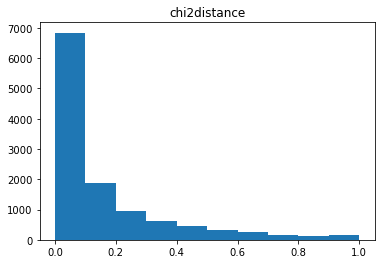

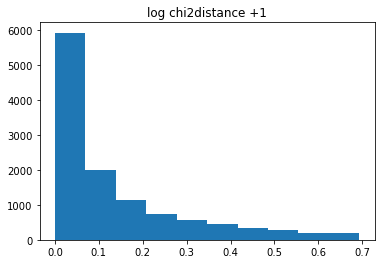

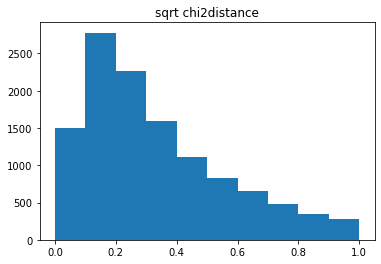

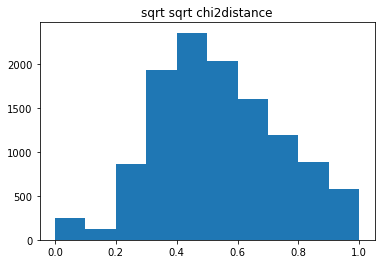

-------------------------------------------- chi2distance_ALL_15
0.0 95.54017640104044


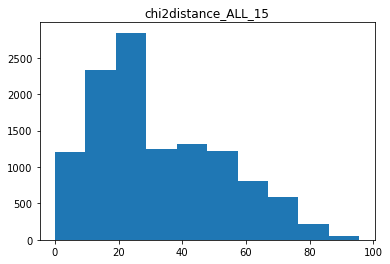

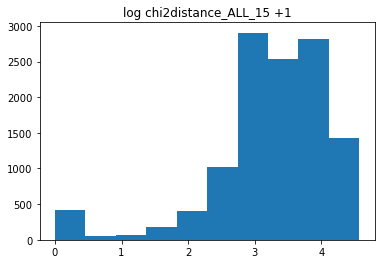

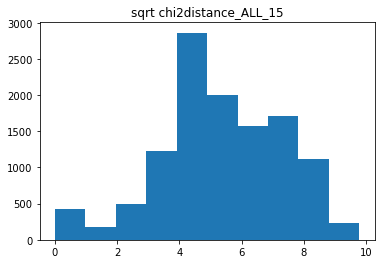

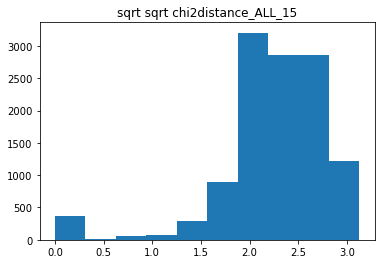

-------------------------------------------- DTW_15_1_Zone
nan nan


C:\Users\camil\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6628: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\camil\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6629: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

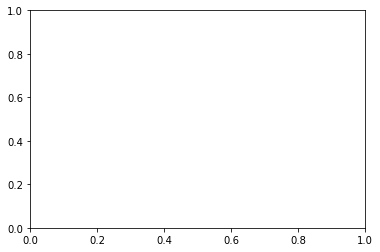

In [66]:
for v in li_dist:
    print('--------------------------------------------', v)
    print(min(df_stat[v].tolist()), max(df_stat[v].tolist()))
    plt.hist(df_stat[v].tolist())
    plt.title(v)
    plt.show()
    plt.hist(np.log(np.array(df_stat[v].tolist())+1))
    plt.title('log '+ v + ' +1')
    plt.show()
    plt.hist(np.sqrt(df_stat[v].tolist()))
    plt.title('sqrt '+ v)
    plt.show()
    plt.hist(np.sqrt(np.sqrt(df_stat[v].tolist())))
    plt.title('sqrt sqrt '+ v)
    plt.show()

# Create the inter distance - intra distance dataframe

In [ ]:
df_interintrea_diff = df_interintra.groupby(['DOA', 'henID1','Treatment'])[['is_same_ind']+li_dist].agg(lambda x: list(x)).reset_index()
for v in li_dist:
    df_interintrea_diff[v+'inter - '+v+'intra'] = df_interintrea_diff.apply(lambda x: x[v][x['is_same_ind'].index(False)]-\
                                                                             x[v][x['is_same_ind'].index(True)],
                                                                   axis=1)
df_interintrea_diff.to_csv(os.path.join(path_extracted_data_visual_adap, 'df_interintrea_diff.csv'),sep=';')
print(df_interintrea_diff.shape)
display(df_interintrea_diff.head(3))

# Association between transitions and distance

#first, merge some info
df_info = pd.merge(df_interintra[df_interintra['type'].isin(['Intra individuals - TRAN', 
                                                             'Intra individuals - OFH'])].filter(li_dist+['henID1','level+1']),
                   df_daily, left_on=['henID1','level+1'], right_on=['HenID','level'])
print(df_info.shape)
df_info.head(3)

In [24]:
#print(list(df_daily.columns))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


def visual_scatterModel(df, x_name, y_name, name_='', path_=None):
    
    x = np.array(df[x_name].tolist())
    y = np.array(df[y_name].tolist())

    #measures
    Explvarscore = explained_variance_score(x, y)
    RMSE = math.sqrt(mean_squared_error(x, y))
    MAE = mean_absolute_error(x, y)
    rcoeff2, p_value2 = pearsonr(x, y)

    #linear model & it's the 95% CI
    slope, intercept = np.polyfit(x, y, 1) #degree=1: fit a linear model
    y_model = np.polyval([slope, intercept], x) #evaluate the y_pred by the model
    x_mean = np.mean(x) ; y_mean = np.mean(y)
    n = x.size                        # number of samples
    dof = n - 2                       # degrees of freedom: size-#parameters
    t_ = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence
    residual = y - y_model

    ############### Plot
    plt.rcParams.update({'font.size': 11})
    fig = plt.figure()
    ax = fig.add_axes([.1, .1, .8, .8])

    #plot points with size equal to the amount of points (as count data)
    # count the occurrences of each point
    #c = Counter(zip(x,y))
    # create a list of the sizes, here multiplied by 10 for scale
    #s = [10*c[(xx,yy)] for xx,yy in zip(x,y)]
    #ax.scatter(x, y, s=s, color = 'royalblue')
    ax.scatter(x, y, color = 'grey')

    #plot middle line and 95% IC
    x_line = np.linspace(np.min(x), np.max(x), 100)
    y_line = np.polyval([slope, intercept], x_line)
    ax.plot(x_line, y_line, color = 'grey')

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(name_)
    #add text
    ax.text(0, max(y)-0.06*max(y), 'Explained variance score = ' + str(np.round(Explvarscore,2)))
    if p_value2<=0.05:
        ax.text(0, max(y)-0.20*max(y), 'Pearson coef = ' + str(np.round(rcoeff2,2)))
    else:
        print('NO SIGNIFICANT PVALUE')

    #add diagonal line
    ax.axline((0, 0), slope=1, c="black", ls="--", zorder=0)

    #save and show
    if path_!=None:
        plt.savefig(os.path.join(path_, x_name+'_'+y_name+".png"), dpi=300,format='png',bbox_inches='tight')
        plt.show();

visual_scatterModel(df_info, x_name='Total_number_transition', y_name='chi2distance')
visual_scatterModel(df_info, x_name='nbr_stays_1_Zone', y_name='DTW_15_1_Zone')
visual_scatterModel(df_info, x_name='nbr_stays_2_Zone', y_name='DTW_15_2_Zone')
visual_scatterModel(df_info, x_name='nbr_stays_3_Zone', y_name='DTW_15_3_Zone')
visual_scatterModel(df_info, x_name='nbr_stays_4_Zone', y_name='DTW_15_4_Zone')
visual_scatterModel(df_info, x_name='nbr_stays_5_Zone', y_name='DTW_15_5_Zone')

sns.scatterplot(data=df_info, x="Total_number_transition", y='chi2distance', hue="weeks_in_laying_barn")
plt.show()
sns.scatterplot(data=df_info, x="nbr_stays_1_Zone", y='DTW_15_1_Zone', hue="weeks_in_laying_barn")
plt.show()
sns.scatterplot(data=df_info, x="nbr_stays_2_Zone", y='DTW_15_2_Zone', hue="weeks_in_laying_barn")
plt.show()
sns.scatterplot(data=df_info, x="nbr_stays_3_Zone", y='DTW_15_3_Zone', hue="weeks_in_laying_barn")
plt.show()
sns.scatterplot(data=df_info, x="nbr_stays_4_Zone", y='DTW_15_4_Zone', hue="weeks_in_laying_barn")
plt.show()
sns.scatterplot(data=df_info, x="nbr_stays_5_Zone", y='DTW_15_5_Zone', hue="weeks_in_laying_barn")
plt.show()

# Overall aviary usage similarity across days

In [ ]:
fig = plt.subplots(figsize=(20,8)) 
hue_order = ['Intra individuals - TRAN','Intra individuals - OFH','Inter individuals - TRAN','Inter individuals - OFH']
sns.boxplot(x="DOA", y="chi2distance", hue="type", data=df_interintra, 
            linewidth=0.8, fliersize=0.7, palette = pal_interintre_treatment, hue_order=hue_order);
plt.savefig(os.path.join(path_extracted_data_visual_adap,'chi2distance_inter&intra_individual_pertreatment_DOA.png'),
            dpi=300,format='png',bbox_inches='tight')

In [ ]:
fig = plt.subplots(figsize=(20,8)) 
hue_order = ['Intra individuals - TRAN','Intra individuals - OFH','Inter individuals - TRAN','Inter individuals - OFH']
sns.boxplot(x="DOA", y="chi2distance_ALL_15", hue="type", data=df_interintra, 
            linewidth=0.8, fliersize=0.7, palette = pal_interintre_treatment, hue_order=hue_order);
plt.savefig(os.path.join(path_extracted_data_visual_adap,'chi2distance_ALL_15_inter&intra_individual_pertreatment_DOA.png'),
            dpi=300,format='png',bbox_inches='tight')

In [ ]:
fig = plt.subplots(figsize=(20,8)) 
hue_order = ['Intra individuals - TRAN','Intra individuals - OFH','Inter individuals - TRAN','Inter individuals - OFH']
sns.boxplot(x="weeks_in_laying_barn", y="chi2distance", hue="type", data=df_interintra, 
            linewidth=0.8, fliersize=0.7, palette = pal_interintre_treatment, hue_order=hue_order);
plt.savefig(os.path.join(path_extracted_data_visual_adap,'chi2distance_inter&intra_individual_pertreatment_weeks_in_laying_barn.png'),
            dpi=300,format='png',bbox_inches='tight')

In [ ]:
fig = plt.subplots(figsize=(20,8)) 
hue_order = ['Intra individuals - TRAN','Intra individuals - OFH','Inter individuals - TRAN','Inter individuals - OFH']
sns.boxplot(x="weeks_in_laying_barn", y="chi2distance_ALL_15", hue="type", data=df_interintra, 
            linewidth=0.8, fliersize=0.7, palette = pal_interintre_treatment, hue_order=hue_order);
plt.savefig(os.path.join(path_extracted_data_visual_adap,'chi2distance_ALL_15_inter&intra_individual_pertreatment_weeks_in_laying_barn.png'),
            dpi=300,format='png',bbox_inches='tight')

fig = plt.subplots(figsize=(20,8)) 
sns.boxplot(x="DOA", y="chi2distance", hue="Treatment", data=df_daily[df_daily['DOA']<=160], linewidth=0.7, fliersize=0.6,
            hue_order=['TRAN','OFH'], palette=pal_treat)
plt.savefig(os.path.join(path_extracted_data_visual_treatmentclass,'chi2distance_intra_individual_treatment_DOA.png'),
            dpi=300,format='png',bbox_inches='tight') 

#fig, ax = plt.subplots(figsize=(15,8)) 
#weeks_in_laying_barn as we have loads of days missing for some pens, and  as similarity depends on two consecutives days, DOA is not oke
#ISSUE: check impact of missing days and impac of WG opening!! on the 8th: 127 DOA
sns.boxplot(x="weeks_in_laying_barn", y="chi2distance", hue="Treatment", data=df_daily, linewidth=0.7, fliersize=0.6,
           hue_order=['TRAN','OFH'], palette=pal_treat);
plt.savefig(os.path.join(path_extracted_data_visual_treatmentclass,'chi2distance_intra_individual_treatment_weeks_in_laying_barn.png'),
            dpi=300,format='png',bbox_inches='tight') 

# % hens not moving

In [ ]:
#min number of birds that must represent a single point
nbr_min_bird = 10

In [ ]:
df_daily_ = df_daily[['DOA','Treatment','CLASS','Total_number_transition','HenID','PenID']].copy()
df_daily_ = df_daily_[~df_daily_.isnull().any(axis=1)]
#add missing hens form the first day due to no mvt (if they were selected and if they were not already in the df_daily)
li_hensavailable = df_daily[df_daily['level']==dt.datetime(2020,10,1)]['HenID'].tolist()
li_hens119 = df_daily[df_daily['level']==dt.datetime(2020,9,30)]['HenID'].tolist()
li_hensmissing = [h for h in li_hensavailable if (h not in li_hens119)&(h in li_selected_hens)]
df_tr = df_daily[['Treatment','HenID']].drop_duplicates()
dico_hen_tr = dict(zip(df_tr['HenID'].tolist(), df_tr['Treatment'].tolist()))
df_cl = df_daily[['CLASS','HenID']].drop_duplicates()
dico_hen_cl = dict(zip(df_cl['HenID'].tolist(), df_cl['CLASS'].tolist()))
df_pen = df_daily[['PenID','HenID']].drop_duplicates()
dico_pen_cl = dict(zip(df_pen['HenID'].tolist(), df_pen['PenID'].tolist()))
df_missed_data = pd.DataFrame([{'DOA':119, 'HenID':h, 'Total_number_transition':0,
                                'Treatment':dico_hen_tr[h], 'CLASS':dico_hen_cl[h], 
                                'PenID':dico_pen_cl[h]} for h in li_hensmissing])
print(df_missed_data.shape)
display(df_missed_data)
df_daily_ = df_daily_.append(df_missed_data, ignore_index=True)
#those two added hens on this visual only are from teh pen 3, which was the very first one during population, so they certainly
#moved before the systesm were on
print(df_daily.shape)
df_daily_.head(3)

### in numbers & two groups selection

In [ ]:
df_daily_.head(3)

In [ ]:
df_ = df_daily_[df_daily_['DOA']<(119+3)].copy()
nbr_days = len(df_['DOA'].unique())
df_ = df_.groupby(['HenID'])[['Total_number_transition','DOA']].agg(lambda x: list(x)).reset_index()
df_['nbr_days_involved'] = df_['Total_number_transition'].map(lambda x: len(x))
df_['nbr_day_notransition'] = df_['Total_number_transition'].map(lambda x: sum([i==0 for i in x]))
df_['has_at_least_one_day_notransition'] = df_['nbr_day_notransition'].map(lambda x: x>0)
df_['always_more_5tran'] = df_['Total_number_transition'].map(lambda x: all([i>=5 for i in x]))
df_['min_nbr_tr'] = df_['Total_number_transition'].map(lambda x: min(x))
print(df_.shape)
display(df_.head(2))
li_hen_NoMvt = df_[df_['has_at_least_one_day_notransition']]['HenID'].unique()
li_hen_Mvt = df_[~df_['has_at_least_one_day_notransition']]['HenID'].unique()
#save the two groups
pickle.dump(li_hen_NoMvt, open(os.path.join(path_extracted_data_visual_adap,'li_hen_NoMvt_'+str(nbr_days)+'days.pkl'), 'wb'))
pickle.dump(li_hen_Mvt, open(os.path.join(path_extracted_data_visual_adap,'li_hen_Mvt_'+str(nbr_days)+'days.pkl'), 'wb'))
print(len(li_hen_NoMvt), len(li_hen_Mvt))
print('%d percent of the hens have at least one day without any movements recorded on the first %d days'%(len(li_hen_NoMvt)/(len(li_hen_Mvt)+len(li_hen_NoMvt))*100,
                                                                                                          nbr_days))
print('We are considering a period of %d days (considering %d days), from DOA %d to %d'% (max(df_daily['DOA'].tolist())-min(df_daily['DOA'].tolist())+1,
                                                                    len(df_daily['DOA'].unique()),
                                                                   min(df_daily_['DOA'].tolist()), max(df_daily_['DOA'].tolist())))

In [ ]:
df_ = df_daily_[df_daily_['DOA']<(119+7)].copy()
nbr_days = len(df_['DOA'].unique())
df_ = df_.groupby(['HenID'])[['Total_number_transition','DOA']].agg(lambda x: list(x)).reset_index()
df_['nbr_days_involved'] = df_['Total_number_transition'].map(lambda x: len(x))
df_['nbr_day_notransition'] = df_['Total_number_transition'].map(lambda x: sum([i==0 for i in x]))
df_['has_at_least_one_day_notransition'] = df_['nbr_day_notransition'].map(lambda x: x>0)
df_['always_more_5tran'] = df_['Total_number_transition'].map(lambda x: all([i>=5 for i in x]))
df_['min_nbr_tr'] = df_['Total_number_transition'].map(lambda x: min(x))
print(df_.shape)
display(df_.head(2))
li_hen_NoMvt = df_[df_['has_at_least_one_day_notransition']]['HenID'].unique()
li_hen_Mvt = df_[~df_['has_at_least_one_day_notransition']]['HenID'].unique()
#save the two groups
pickle.dump(li_hen_NoMvt, open(os.path.join(path_extracted_data_visual_adap,'li_hen_NoMvt_'+str(nbr_days)+'days.pkl'), 'wb'))
pickle.dump(li_hen_Mvt, open(os.path.join(path_extracted_data_visual_adap,'li_hen_Mvt_'+str(nbr_days)+'days.pkl'), 'wb'))
print(len(li_hen_NoMvt), len(li_hen_Mvt))
print('%d percent of the hens have at least one day without any movements recorded on the first %d days'%(len(li_hen_NoMvt)/(len(li_hen_Mvt)+len(li_hen_NoMvt))*100,
                                                                                                          nbr_days))
print('We are considering a period of %d days, from DOA %d to %d'% (max(df_daily['DOA'].tolist())-min(df_daily['DOA'].tolist()),
                                                                   min(df_daily_['DOA'].tolist()), max(df_daily_['DOA'].tolist())))

In [ ]:
df_plt = df_daily_.groupby(['DOA','Treatment','PenID'])['Total_number_transition'].agg(lambda x: list(x)).reset_index()
#df_plt = df_plt.sort_values('DOA')
#df_plt['DOA'].unique() #verificaiton: OK: 127 and 128 are not included
df_plt['nbr_birds'] = df_plt['Total_number_transition'].map(lambda x: len(x))
#take only when there is at least x birds in the the point
print(df_plt.shape)
display(df_plt[df_plt['nbr_birds']<nbr_min_bird])
df_plt = df_plt[df_plt['nbr_birds']>=nbr_min_bird]
print(df_plt.shape)
plt.hist(df_plt['nbr_birds'].tolist())
plt.show()
df_plt['Percentage not moving'] = df_plt['Total_number_transition'].map(lambda x: sum([i==0 for i in x])/len(x)*100)
df_plt.sort_values(['DOA'], inplace=True)
print(df_plt.shape)
display(df_plt.head(3))

#visual
plt.figure(figsize=(12,6))
ax = plt.plot()
sns.lineplot(x="DOA", y='Percentage not moving', hue='Treatment', data=df_plt, palette=pal_treat)
plt.title('Percentage of hens with 0 transitions over the day')
plt.ylabel('percentage')
plt.xlabel('day of age')
plt.savefig(os.path.join(path_extracted_data_visual_adap, 'Barplot%Hens0Transition_per_treatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()
#boxplot to have average values
nbr_day_ = 21
testPlot = sns.boxplot(x="Treatment", y='Percentage not moving', data=df_plt[df_plt['DOA']<119+nbr_day_], palette=pal_treat)
m1 = df_plt[df_plt['DOA']<119+nbr_day_].groupby(['Treatment'])['Percentage not moving'].median().values
mL1 = [str(np.round(s, 2)) for s in m1]
m2 = df_plt[df_plt['DOA']<119+nbr_day_].groupby(['Treatment'])['Percentage not moving'].mean().values
print('MEAN:')
display(m2)
m3 = df_plt[df_plt['DOA']<119+nbr_day_].groupby(['Treatment'])['Percentage not moving'].std().values
print('STD:')
display(m3)
mL2 = [str(np.round(s, 2)) for s in m2]
ind = 0
for tick in range(len(testPlot.get_xticklabels())):
    print(tick)
    testPlot.text(tick+.2, m1[ind]+1, mL1[ind], horizontalalignment='center', color='black', weight='semibold')
    #testPlot.text(tick+.2, m2[ind]+1, mL2[ind], horizontalalignment='center', color='black', weight='semibold')
    ind = ind+1
plt.title('first %d days - percent of hens with 0 transitions over the day'%nbr_day_)
plt.ylabel('percentage')
plt.savefig(os.path.join(path_extracted_data_visual_adap, 'Boxplot%Hens0Transition_per_treatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

#stat
df_stat = df_plt[df_plt['DOA']<119+nbr_day_].copy()
df_stat.drop(['Total_number_transition'], axis=1, inplace=True)
df_stat.rename(columns={'Percentage not moving':'Percentagenotmoving'}, inplace=True)
display(df_stat.head(3))
df_stat.to_csv(os.path.join(path_extracted_data_visual_adap, 'STATpercentgaeHensNotMovingTreatmentPenmonth1.csv'),sep=';')

In [ ]:
df_plt[df_plt['DOA']<119+nbr_day_].groupby(['Treatment'])['Percentage not moving'].agg(lambda x: list(x)).reset_index()

In [ ]:
df_verification = df_daily_.groupby(['DOA','Treatment','PenID'])['Total_number_transition'].agg(lambda x: list(x)).reset_index()
df_verification[df_verification['DOA'].isin([122,124])]

In [ ]:
#remove unwanted class
df_plt = df_daily_[df_daily_['CLASS'].isin(['MEXP','LEXP'])].copy()
print(df_plt.shape)

#groupby DOA
df_plt = df_plt.groupby(['DOA','CLASS'])['Total_number_transition'].agg(lambda x: list(x)).reset_index()
df_plt['nbr_birds'] = df_plt['Total_number_transition'].map(lambda x: len(x))

#take only when there is at least x birds in the the point
print(df_plt.shape)
display(df_plt[df_plt['nbr_birds']<nbr_min_bird])
df_plt = df_plt[df_plt['nbr_birds']>=nbr_min_bird]
print(df_plt.shape)
plt.hist(df_plt['nbr_birds'].tolist())
plt.show()
df_plt['Percentage not moving'] = df_plt['Total_number_transition'].map(lambda x: sum([i==0 for i in x])/len(x)*100)
display(df_plt.head(3))
df_plt.sort_values(['DOA'], inplace=True)
fig = plt.subplots(figsize=(20,8)) 
sns.pointplot(x="DOA", y="Percentage not moving", data=df_plt, hue='CLASS', hue_order=['LEXP','MEXP'],
                 palette=pal_class, alpha=0.7)
df_plt.to_csv(os.path.join(path_extracted_data_visual_adap, id_run+'_percentgaeHensNotMovingClass.csv'),sep=';')
plt.title('Percentage of hens with 0 transitions over the day')
plt.ylabel('percentage')
plt.xlabel('day of age')
plt.savefig(os.path.join(path_extracted_data_visual_adap, 'Barplot%Hens0Transition_per_CLASS.png'),dpi=300,format='png',bbox_inches='tight')

# distance inter-distance intra AND OFH intra vs TRAN intra

In [ ]:
#OFH vs TRAN of : distance inter - distance intra to compare treatments developement of patterns / consistency
for v in li_dist:
    fig, ax = plt.subplots(figsize=(20,8)) 
    graph = sns.violinplot(x="DOA", y=v+'inter - '+v+'intra', hue="Treatment", data=df_interintrea_diff, 
                fliersize=4, palette = pal_treat, hue_order=['TRAN', 'OFH'], ax=ax);
    #plot black line at y=0 (i.e. not difference between inter and intra similarity)
    graph.axhline(0, color='black')
    plt.title('difference between Inter'+v+' and Intra'+v)
    plt.savefig(os.path.join(path_extracted_data_visual_adap,v+'_inter-intra_individual_pertreatment_violin.png'),
                dpi=300,format='png',bbox_inches='tight')

In [ ]:
#intra similarity/distance vs inter similarity/distance to comapre the variability of the movements similiarities within and between individuals
for v in li_dist:
    fig = plt.subplots(figsize=(20,8)) 
    hue_order = ['Intra individuals - TRAN','Intra individuals - OFH','Inter individuals - TRAN','Inter individuals - OFH']
    sns.boxplot(x="DOA", y=v, hue="is_same_ind", data=df_interintra, 
                 linewidth=0.8, fliersize=1, palette = {True:'tan', False:'beige'}, hue_order=[True,False]);
    plt.title('Inter '+v+' and Intra '+v)
    plt.savefig(os.path.join(path_extracted_data_visual_adap,v+'_inter&intra_individual_DOA.png'),
                dpi=300,format='png',bbox_inches='tight')

# Specifics' zones usage similarity across days

In [ ]:
hue_order = ['Intra individuals - TRAN','Intra individuals - OFH','Inter individuals - TRAN','Inter individuals - OFH']
for ZONE in ['1_Zone', '2_Zone', '3_Zone', '4_Zone','5_Zone']:
    for nbr_binmn in li_binmn:
        dtw_name = 'DTW_'+str(nbr_binmn)+'_'+ZONE
        for t in ['DOA','weeks_in_laying_barn']:
            fig = plt.subplots(figsize=(20,8)) 
            sns.boxplot(x=t, y=dtw_name,  data=df_interintra, linewidth=0.8, fliersize=0.7, hue="type", 
                        palette=pal_interintre_treatment, hue_order=hue_order);
            plt.title(ZONE)
            plt.savefig(os.path.join(path_extracted_data_visual_adap,str(nbr_binmn),
                                     dtw_name+'_inter&intra_individual_pertreatment_'+t+'.png'),
                        dpi=300,format='png',bbox_inches='tight')
            #plt.show()
            plt.close()

In [ ]:
hue_order = ['LEXP', 'MEXP']
for ZONE in ['1_Zone', '2_Zone', '3_Zone', '4_Zone','5_Zone']:
    for nbr_binmn in li_binmn:
        dtw_name = 'DTW_'+str(nbr_binmn)+'_'+ZONE
        for t in ['DOA','weeks_in_laying_barn']:
            fig = plt.subplots(figsize=(20,8)) 
            sns.boxplot(x=t, y=dtw_name, data=df_interintra[(df_interintra['CLASS'].isin(['MEXP','LEXP']))&\
                                                              (df_interintra['type'].isin(['Intra individuals - TRAN',
                                                                                           'Intra individuals - OFH']))], 
                        linewidth=0.8, fliersize=0.7, hue="CLASS", palette=pal_class, hue_order=hue_order);
            plt.title(ZONE +' Intra individuals')
            plt.savefig(os.path.join(path_extracted_data_visual_adap,str(nbr_binmn),
                                                  dtw_name+'_intra_individual_perclass_'+'_'+t+'.png'),
                        dpi=300, format='png', bbox_inches='tight')
            #plt.show()
            plt.close()

# Behavioural difference

In [ ]:
#we dont choose the transition as transitional zones are mmore likely, and for the adaptability study we have the birds not moving
#at all which will have 0 transitions: night_Total_number_transition: would need more verification
#not down_missingZone_mvtPerc as to many things but up_missingZone_mvtPerc as means efficient
#distribution_entropy: not as only will distinguish between birds having long stay in zone 4
#'TimeFirstVisitLonger15mn-TimeFirstVisit_mn': had to interpret as no real nestbox
#night_Max_duration_zones: def: where the hens staid the longest consecutively
#activity_xpercentile_sec not used as different horaire
#one model on night main zone!
li_all = ['percentage_time_outside_while_WG_open','perc_duration_2_Zone', 'perc_duration_3_Zone', 'perc_duration_4_Zone',
          'perc_duration_5_Zone',
         'in_WG_15mnAfterOpening','up_missingZone_mvtPerc','vertical_travel_distance','sucessIntrusion_9','is_max_nightzone_duration_zonelitterORlowerperch']
print(len(li_all))

In [ ]:
c = 5
l = math.ceil(len(li_all)/5) #round up
img_w = 6 
img_h = 4 
fig = plt.figure(figsize=(int(c*img_w), int(l*img_h)))
i = 1
for x in li_all:
    #print(x)
    plt.subplot(l,c,i)
    plt.tight_layout()
    df_plt = df_daily[['HenID','DOA',x,'Treatment']].copy()
    df_plt = df_plt[~df_plt.isnull().any(axis=1)]
    sns.lineplot(data=df_plt, x="DOA", y=x, hue='Treatment', palette=pal_treat, hue_order=['TRAN','OFH'])
    i = i+1
plt.savefig(os.path.join(path_extracted_data_visual_adap, 'Treatment_Adaptability.png'), bbox_inches='tight')
print(df_plt.shape)
display(df_plt.head(3))
plt.show();

In [ ]:
c = 5
l = math.ceil(len(li_all)/5) #round up
img_w = 6 
img_h = 4 
fig = plt.figure(figsize=(int(c*img_w), int(l*img_h)))
i = 1
for x in li_all:
    #print(x)
    plt.subplot(l,c,i)
    plt.tight_layout()
    df_plt = df_daily[df_daily['CLASS'].isin(['LEXP','MEXP'])][['HenID','DOA',x,'CLASS']].copy()
    df_plt = df_plt[~df_plt.isnull().any(axis=1)]
    sns.lineplot(data=df_plt, x="DOA", y=x, hue='CLASS', palette=pal_class, hue_order=['LEXP','MEXP'])
    i = i+1
plt.savefig(os.path.join(path_extracted_data_visual_adap,'CLASS_Adaptability.png'), bbox_inches='tight')
print(df_plt.shape)
display(df_plt.head(3))
plt.show();